# Inference with original cnn_virus trained model

This notebook is a guide showing how to experiment with the pretrained model
- infer/predict virus from the original data available with the paper
- compare the predictions with the real virus labels

# Imports and setup environment

### Install and import packages

In [ ]:
# Install required custom packages if not installed yet.
import importlib.util
if not importlib.util.find_spec('ecutilities'):
    print('installing package: `ecutilities`')
    ! pip install -qqU ecutilities
else:
    print('`ecutilities` already installed')
if not importlib.util.find_spec('metagentools'):
    print('installing package: `metagentools')
    ! pip install -qqU metagentools
else:
    print('`metagentools` already installed')

`ecutilities` already installed
`metagentools` already installed


In [ ]:
# Import all required packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import scipy
import seaborn as sns

from ecutilities.core import files_in_tree
from ecutilities.ipython import nb_setup
from pathlib import Path
from pprint import pprint

# Setup the notebook for development
nb_setup()


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.models import load_model
print(f"Tensorflow version: {tf.__version__}\n")

from metagentools.cnn_virus.data import strings_to_tensors, create_infer_ds_from_fastq
from metagentools.cnn_virus.data import FastaFileReader, FastqFileReader, AlnFileReader
from metagentools.core import TextFileBaseIterator, TextFileBaseReader, ProjectFileSystem

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Set autoreload mode
Tensorflow version: 2.8.2



In [ ]:
devices = device_lib.list_local_devices()
print('\nDevices:')
for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':', 1) for item in name.split(', ')]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', ' ')
    print(f"  - {t}  {d.name} {dev:25s}")


Devices:
  - CPU  /device:CPU:0                          
  - GPU  /device:GPU:0  NVIDIA GeForce GTX 1050 


# 2. Setup paths to files

Key folders and system information

In [ ]:
pfs = ProjectFileSystem()
pfs.info()

Running linux on local computer
Device's home directory: /home/vtec
Project file structure:
 - Root ........ /home/vtec/projects/bio/metagentools 
 - Data Dir .... /home/vtec/projects/bio/metagentools/data 
 - Notebooks ... /home/vtec/projects/bio/metagentools/nbs


In [ ]:
pfs.readme()

ReadMe file for directory `data`:

### Data structure for `metagentools`
This directory includes all the data required for the project `metagentools`.

```text
data
 |--- CNN_Virus_data 
 |--- ncbi           
 |--- ncov_data      
 |--- saved         
 |--- ....           
     
```
#### Sub-directories
- `CNN_Virus_data`: includes all the data related to the original CNN Virus paper, i.e. training data and validation data in a format that can be used by the CNN Virus code.
- `ncbi`: includes data related to the use of CoV sequences from NCBI: reference sequences, simulated reads, inference datasets, inference results.
- `ncov_data`: includes data related to the use of non Cov sequences from various sources: reference sequences, simulated reads, inference datasets, inference results.
- `saved`: includes model saved parameters and preprocessing datasets.


- `p2model`: path to file with saved original pretrained model
- `p2virus_labels` path to file with virus names and labels mapping for original model
- `p2original`: path to the directory with all paper files

In [ ]:
p2model = pfs.data / 'saved/cnn_virus_original/pretrained_model.h5'
assert p2model.is_file(), f"No file found at {p2model.absolute()}"

p2virus_labels = pfs.data / 'CNN_Virus_data/virus_name_mapping'
assert p2virus_labels.is_file(), f"No file found at {p2virus_labels.absolute()}"

p2original = pfs.data / 'CNN_Virus_data'
assert p2original.is_dir(), f"No directory found at {p2original.absolute()}"

In [ ]:
files_in_tree(path=p2original);

data
  |--CNN_Virus_data
  |    |--50mer_validating (0)
  |    |--50mer_ds_100_reads (1)
  |    |--validation_sequences.fasta (2)
  |    |--ICTV_150mer_benchmarking (3)
  |    |--readme.md (4)
  |    |--50mer_training (5)
  |    |--training_sequences_500bp.fasta (6)
  |    |--weight_of_classes (7)
  |    |--150mer_ds_100_reads (8)
  |    |--virus_name_mapping (9)
  |    |--training_sequences_300bp.fasta (10)


# 3. Create inference dataset

The file `50mer_validating` is a validation dataset already in the expected format


```text
AAAAAGATTTTGAGAGAGGTCGACCTGTCCTCCTAAAACGTTTACAAAAG	71	0
CATGTAACGCAGCTTAGTCCGATCGTGGCTATAATCCGTCTTTCGATTTG	1	7
AACAACATCTTGTTGATGATAACCGTCAAAGTGTTTTGGGTCTGGAGGGA	158	6
AGTACCTGGAGAGCGTTAAGAAACACAAACGGCTGGATGTAGTGCCGCGC	6	7
CCACGTCGATGAAGCTCCGACGAGAGTCGGCGCTGAGCCCGCGCACCTCC	71	6
```

Each line corresponds to a **read sequence**. During inference, the model will predict the **virus species code** and the **relative position** of the read in the full reference sequence.

The mapping between code and virus specie name are in the file `virus_labels.csv`

In [ ]:
p2ds = p2original / '50mer_validating'
val = TextFileBaseReader(p2ds, nlines=10)
val.print_first_chunks(nchunks=1)

10-line chunk 1
AAAAAGATTTTGAGAGAGGTCGACCTGTCCTCCTAAAACGTTTACAAAAG	71	0
CATGTAACGCAGCTTAGTCCGATCGTGGCTATAATCCGTCTTTCGATTTG	1	7
AACAACATCTTGTTGATGATAACCGTCAAAGTGTTTTGGGTCTGGAGGGA	158	6
AGTACCTGGAGAGCGTTAAGAAACACAAACGGCTGGATGTAGTGCCGCGC	6	7
CCACGTCGATGAAGCTCCGACGAGAGTCGGCGCTGAGCCCGCGCACCTCC	71	6
AGCTCGTGGATCTCCCCTCCTTCTGCAGTTTCAACATCAGAAGCCCTGAA	87	1
GACTCTGTGTTTATGTATCAGCATACAGAGCTTATGCAGAAGAACGCGTC	10	0
CGTCATGAGGAAGTTGCTAATAATATGTGGATGCATGCATTCCTCTGGGT	178	7
TTCACCTTGAGCAAGGGCAGGTTGAACACGCGGCTGACATCGCCGTCGTA	71	3
CAAAACTTTCACCGGGGTTCCAATCCGCGGTGGTAATGACGTTNTGCTGT	22	6



## Create the data loader for the model 

Define batch size and create a first dataset accessing data from the dataset text file. Batch size can be adjusted depending on the memory available on the GPU. For reference, `bs = 4096` was used with a 4GB GPU. 

Then transform the text dataset into a tensor dataset by applying the `string_to_tensor` preprocessing function

In [ ]:
bs = 4096

text_ds = tf.data.TextLineDataset(p2ds).batch(bs)
ds = text_ds.map(strings_to_tensors)

The bases in the read sequences are encoded as a 5-dim one-hot-encoded vector, as the model expects.

In this example, each 50bp read in converted into a tensor of shape [50,5]

In [ ]:
for batch, (y1b, y2b) in ds.take(1):
    # show the shape of one batch
    print(batch.shape)
    # show the forst 10 bases, after one-hot-endoding
    print(batch[0, :10, :])

(4096, 50, 5)
tf.Tensor(
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]], shape=(10, 5), dtype=float32)


# Experiments with original data

##  Setup paths

In [ ]:
p2model = pfs.data / 'saved/cnn_virus_original/pretrained_model.h5'
assert p2model.is_file(), f"No file found at {p2model.absolute()}"

## Load pretrained model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

In [ ]:
model = load_model(p2model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 5)]      0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 50, 512)      13312       ['input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 50, 512)     2048        ['conv1d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 25, 512)     0           ['batch_normalization_1[0][

## Inference/Prediction with Original Data

In [ ]:
prob_preds_species, prob_preds_loc  = model.predict(ds, verbose=1)

245/245 [==============================] - 250s 909ms/step


In [ ]:
prob_preds_species.shape, prob_preds_loc.shape

((1000000, 187), (1000000, 10))

In [ ]:
class_preds = np.argmax(prob_preds_species, axis=1)
class_preds[:10]

array([ 71,   1, 158,   6,  71,  87,  10, 178,  71,  22])

## Evaluate and analyse predictions

Convert targets (true virus label) from one-hot-encoded vector to integers

In [ ]:
class_labels_ohe = None
for xb, (y_label, y_pos_) in ds:
    class_labels_ohe = tf.concat([class_labels_ohe, y_label], axis=0) if class_labels_ohe is not None else y_label
class_labels = np.argmax(class_labels_ohe, axis=1)
class_labels[:10]

array([ 71,   1, 158,   6,  71,  87,  10, 178,  71,  22])

Evaluate the accurary of the prediction

In [ ]:
acc = tf.keras.metrics.Accuracy()
accuracy = acc(class_labels, class_preds).numpy()
print(f"Prediction accuracy on the validation dataset is {accuracy:.2%}")

Prediction accuracy on the validation dataset is 94.75%


Evaluate precision and recall

In [ ]:
from sklearn.metrics import precision_score, recall_score

`average`
- `binary`: Only report results for the class specified by ``pos_label``. This is applicable only if targets (``y_{true,pred}``) are binary.
- `micro`: Calculate metrics globally by counting the total true positives, false negatives and false positives.
- `macro`: Calculate metrics for each label, and find their unweighted mean.  This does not take label imbalance into account.

In [ ]:
precision = precision_score(class_labels, class_preds, average='macro')
print(f"Prediction precision on the validation dataset is {precision:.2%}")

Prediction precision on the validation dataset is 95.72%


In [ ]:
recall = recall_score(class_labels, class_preds, average='macro')
print(f"Prediction recall on the validation dataset is {recall:.2%}")

Prediction recall on the validation dataset is 94.97%


**Confusion Matrix**

The matrix **columns** represent the prediction labels and the **rows** represent the real labels. 

In [ ]:
confmat = tf.math.confusion_matrix(class_labels, class_preds)
confmat.shape

TensorShape([187, 187])

In [ ]:
confmat[:5,:5]

<tf.Tensor: shape=(5, 5), dtype=int32, numpy=
array([[30620,     2,     0,     3,    55],
       [    0,  4216,     3,     0,     4],
       [    4,     0, 36028,    13,    22],
       [    4,     1,    25,  6861,     7],
       [   57,     3,    18,     2, 27612]], dtype=int32)>

Values in the diagonal are very large and the others small and vary a lot. 

We will create a matrix where the diagonal is set to 0 and then we will focus only on the non-zero error counts, or the small error counts.

In [ ]:
# np.fill_diagonal?

In [ ]:
confmat_no_diag = confmat.numpy().copy()
np.fill_diagonal(confmat_no_diag, 0)
confmat_no_diag[:5,:5]

array([[ 0,  2,  0,  3, 55],
       [ 0,  0,  3,  0,  4],
       [ 4,  0,  0, 13, 22],
       [ 4,  1, 25,  0,  7],
       [57,  3, 18,  2,  0]], dtype=int32)

In [ ]:
non_zeroes = confmat_no_diag.flatten()[confmat_no_diag.flatten() > 0]

small_counts_threshold = 25
small_counts = confmat_no_diag.flatten()[(confmat_no_diag.flatten() > 0) & (confmat_no_diag.flatten() < small_counts_threshold)]
large_counts = confmat_no_diag.flatten()[(confmat_no_diag.flatten() > small_counts_threshold)]

np.median(non_zeroes), np.percentile(non_zeroes, 80), non_zeroes.max(), np.median(large_counts)

(1.0, 3.0, 4069, 54.0)

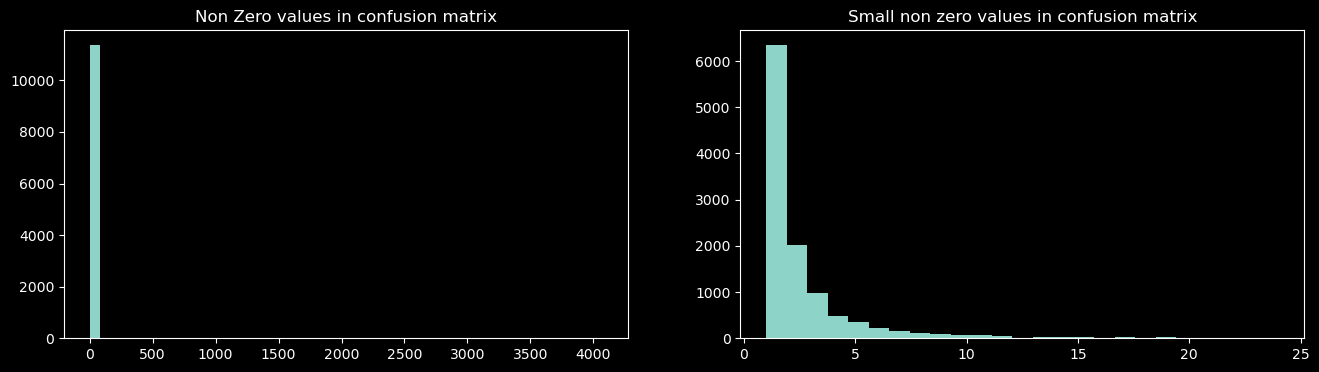

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.hist(non_zeroes, bins=50)
ax1.set_title('Non Zero values in confusion matrix')
ax2.hist(small_counts, bins=25)
ax2.set_title('Small non zero values in confusion matrix')
plt.show()

In [ ]:
print(f"The maximum number of errors is:  {confmat_no_diag.max():,d}")
print(f"The median number of error is:    {np.median(confmat_no_diag)}")
pct = 99
print(f"{pct}% of the error counts are below: {np.percentile(confmat_no_diag, 99)}")
print(f"{pct}% of the error counts are below: {np.percentile(confmat.numpy(), 99)}")

The maximum number of errors is:  4,069
The median number of error is:    0.0
99% of the error counts are below: 15.0
99% of the error counts are below: 27.0


In [ ]:
# np.argmax?
idx_max_error = np.argmax(confmat_no_diag)
idx_max_error
horiz_idx = idx_max_error % confmat_no_diag.shape[0]
vert_idx = idx_max_error // confmat_no_diag.shape[0]
horiz_idx, vert_idx

with open(p2virus_labels, 'r') as f:
    virus_names = [line.strip().split('\t')[0] for line in f.readlines()]

print(f"Most errors between <{virus_names[horiz_idx]}> and <{virus_names[vert_idx]}>")

Most errors between <Monkeypox_virus> and <Variola_virus>


Review full confusion matrix

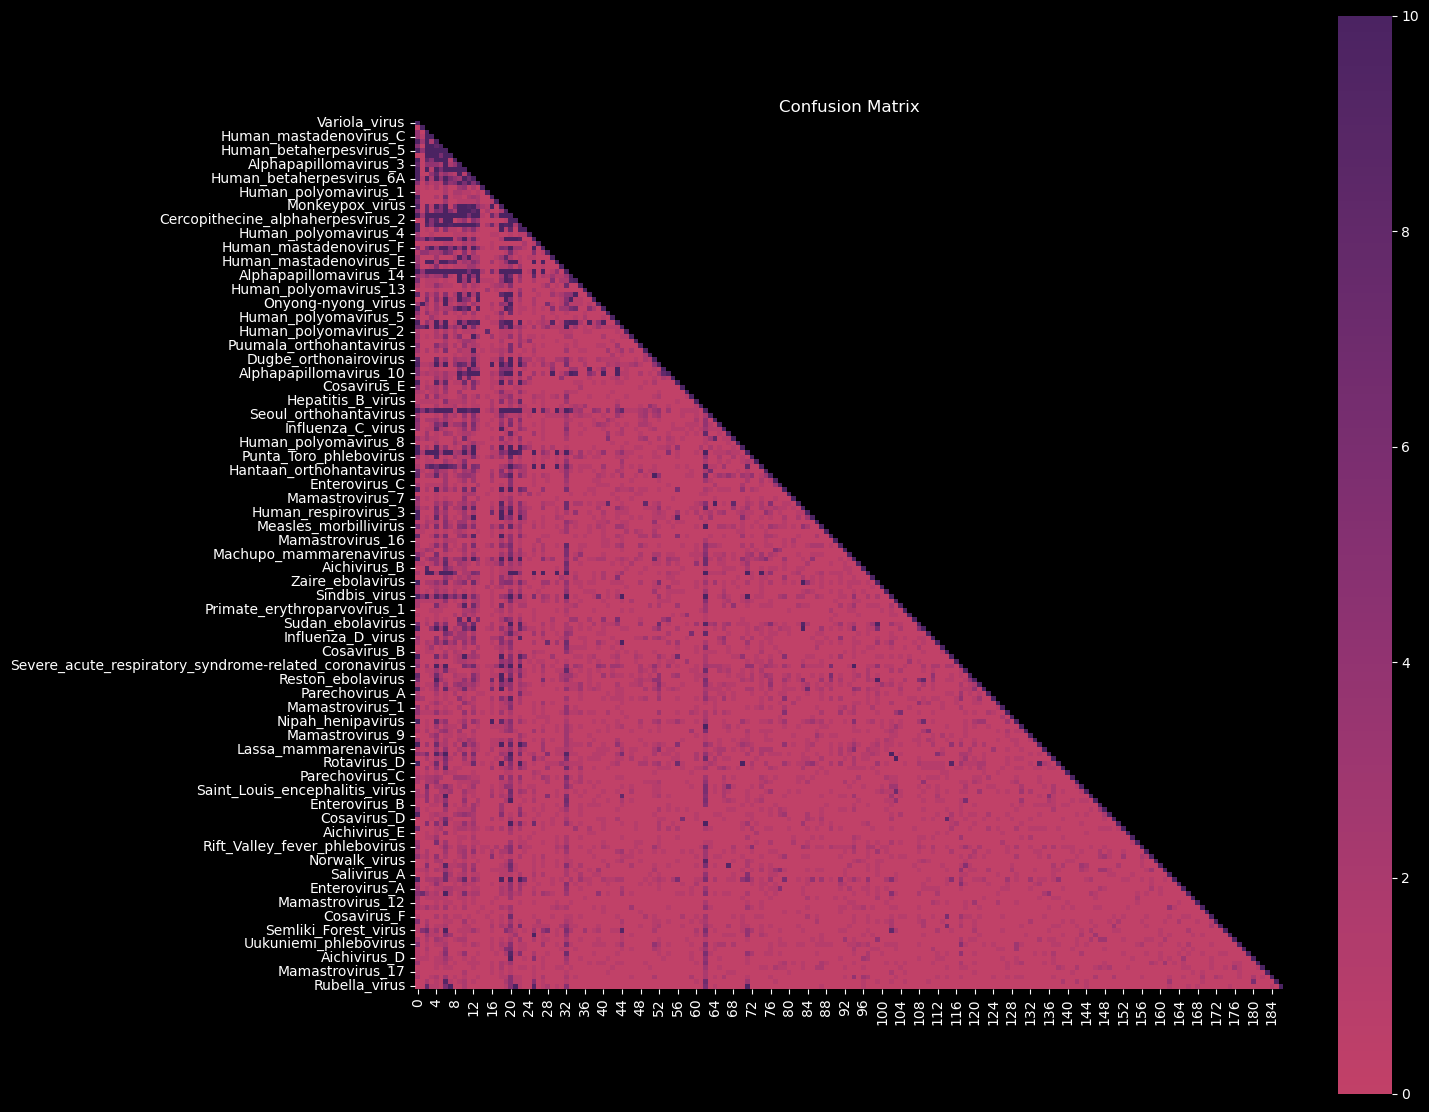

In [ ]:
mask = np.triu(np.ones_like(confmat), k=1).astype(bool)
confmat_df = pd.DataFrame(data=confmat.numpy(), columns=None, index=virus_names)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap = sns.color_palette("flare", as_cmap=True)

fig, ax = plt.subplots(1, 1, figsize=(14,14))
ax.set_ylabel('Actuals')
ax.set_xlabel('Predictions')
ax.set_title('Confusion Matrix')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(confmat_df, center=0, vmax=10, cmap=cmap, square=True, ax=ax, mask=mask);

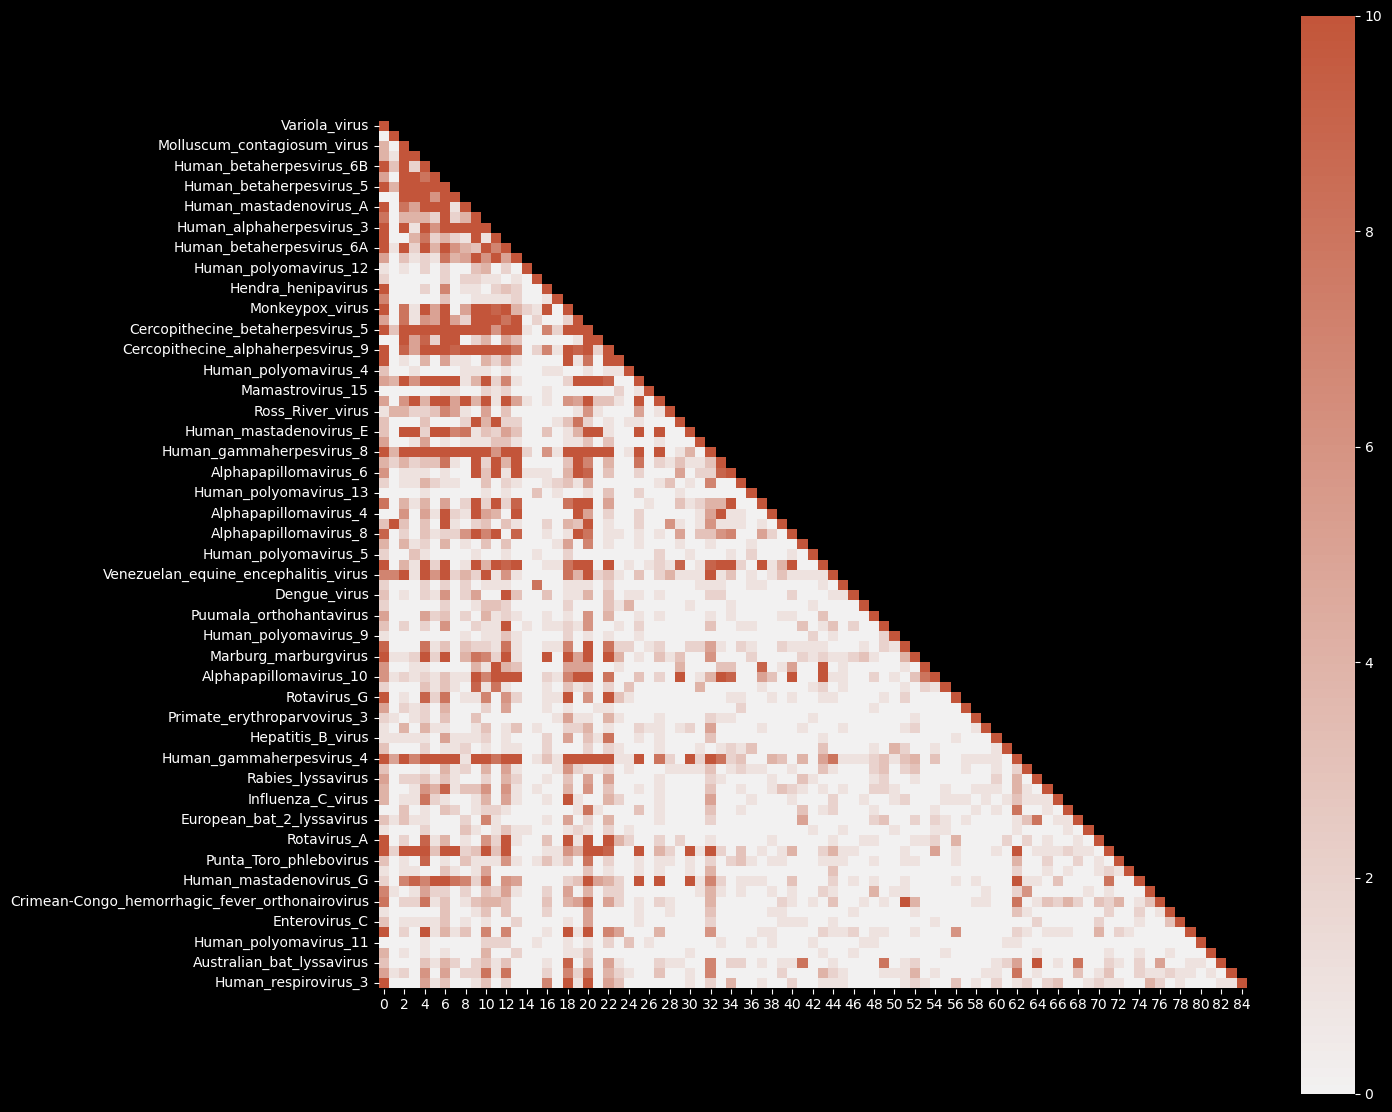

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14,14))
max_idx = 85
sns.heatmap(confmat_df.iloc[:max_idx,:max_idx], center=0, vmax=10, cmap=cmap, square=True, ax=ax, mask=mask[:max_idx,:max_idx]);

In [ ]:
print('Viruses with systematic errors close to 10:')
for n in [0, 4, 6, 12, 18, 20, 32, 62 ]:
    virus_name = virus_names[n]
    print(f" - {virus_name}")

Viruses with systematic errors close to 10:
 - Variola_virus
 - Human_betaherpesvirus_6B
 - Human_betaherpesvirus_5
 - Human_betaherpesvirus_6A
 - Monkeypox_virus
 - Cercopithecine_betaherpesvirus_5
 - Human_gammaherpesvirus_8
 - Human_gammaherpesvirus_4


In [ ]:
true_nbr_samples_per_virus = confmat.numpy().sum(axis=1)
pred_nbr_samples_per_virus = confmat.numpy().sum(axis=0)
# print(true_nbr_samples_per_virus)
# print(pred_nbr_samples_per_virus)

In [ ]:
val_prec = np.diagonal(confmat.numpy()) / pred_nbr_samples_per_virus
# print(val_prec)

In [ ]:
val_recall = np.diagonal(confmat.numpy()) / true_nbr_samples_per_virus
# print(val_recall)

Get indexes to sort the precision and recall from smallest to largest

In [ ]:
n = 50
idx_smallest_prec = np.argsort(val_prec)[0:n]
display(idx_smallest_prec)

idx_smallest_recall = np.argsort(val_recall)[0:n]
display(idx_smallest_recall)

idx_smallest_prec_and_recall = np.array(list(set(idx_smallest_prec).intersection(set(idx_smallest_recall))))
idx_smallest_prec_and_recall

array([  0,  18,  12,   4,  74,  16,  27,  79,  66, 129, 181,  76,  94,
       173, 114, 176, 120,  64, 148,  25,  91, 127,   5,  42,  98,  72,
        99, 145, 117,  89,  97,   6,  56, 137,  86,  78,   8, 112, 106,
       109, 134,  31, 177, 164, 126,  20,  47, 160, 144,  92])

array([  0,  18,   4,  12, 178, 161,  61,  82, 112, 133, 116,  90, 141,
       108,  46,  30, 151,  97, 149, 163, 142, 138,  77,  92, 179, 157,
       158,  14, 152, 119,  84, 120, 109, 124,  55,  87, 137,  89,  58,
         3,  41,  93, 166, 173,  45, 150, 107,  51,   7, 154])

array([  0,  97,   4, 137,  12, 173, 109, 112,  18, 120,  89,  92])

In [ ]:
p2virus_class_mapping = pfs.data /'CNN_Virus_data/virus_name_mapping'
with open(p2virus_class_mapping, 'r') as fp:
    label2virus = []
    virus2label = {}
    while True:
        line = fp.readline()[:-1]
        if line == '': break
        virus, label = line.split('\t')
        label2virus.append(virus)
        virus2label[virus] = label
label2virus=np.array(label2virus)

In [ ]:
print(f"List of the {n} viruses with the smallest precision:")
for i, txt in enumerate(label2virus[idx_smallest_prec].tolist()):
    print(f" {i+1:02d}. {txt}")

List of the 50 viruses with the smallest precision:
 01. Variola_virus
 02. Monkeypox_virus
 03. Human_betaherpesvirus_6A
 04. Human_betaherpesvirus_6B
 05. Human_mastadenovirus_G
 06. Hendra_henipavirus
 07. Human_mastadenovirus_F
 08. Rotavirus_B
 09. Influenza_C_virus
 10. Nipah_henipavirus
 11. Enterovirus_K
 12. Crimean-Congo_hemorrhagic_fever_orthonairovirus
 13. Middle_East_respiratory_syndrome-related_coronavirus
 14. Cosavirus_A
 15. Cosavirus_B
 16. Enterovirus_I
 17. Reston_ebolavirus
 18. Rabies_lyssavirus
 19. Enterovirus_D
 20. Human_alphaherpesvirus_1
 21. Mumps_rubulavirus
 22. Chandipura_vesiculovirus
 23. Human_mastadenovirus_B
 24. Human_polyomavirus_5
 25. Mupapillomavirus_2
 26. Punta_Toro_phlebovirus
 27. Zaire_ebolavirus
 28. Eastern_equine_encephalitis_virus
 29. Severe_acute_respiratory_syndrome-related_coronavirus
 30. Oropouche_orthobunyavirus
 31. Human_mastadenovirus_D
 32. Human_betaherpesvirus_5
 33. Rotavirus_G
 34. Japanese_encephalitis_virus
 35. Mamas

In [ ]:
print(f"List of the {n} viruses with the smallest precision:")
for i, txt in enumerate(label2virus[idx_smallest_recall].tolist()):
    print(f" {i:02d}. {txt}")

List of the 50 viruses with the smallest precision:
 00. Variola_virus
 01. Monkeypox_virus
 02. Human_betaherpesvirus_6B
 03. Human_betaherpesvirus_6A
 04. Mamastrovirus_14
 05. Enterovirus_J
 06. Human_polyomavirus_10
 07. Australian_bat_lyssavirus
 08. Barmah_Forest_virus
 09. Mamastrovirus_6
 10. Primate_erythroparvovirus_4
 11. Mamastrovirus_16
 12. Parechovirus_C
 13. Sudan_ebolavirus
 14. Dengue_virus
 15. Human_mastadenovirus_E
 16. Rosavirus_A
 17. Human_mastadenovirus_D
 18. Rhinovirus_B
 19. Banna_virus
 20. Rhinovirus_C
 21. Rotavirus_D
 22. Enterovirus_E
 23. Enterovirus_F
 24. Sapporo_virus
 25. Enterovirus_H
 26. Enterovirus_L
 27. Human_polyomavirus_12
 28. Rhinovirus_A
 29. Bunyamwera_orthobunyavirus
 30. Human_respirovirus_3
 31. Reston_ebolavirus
 32. Tai_Forest_ebolavirus
 33. Lymphocytic_choriomeningitis_mammarenavirus
 34. Mupapillomavirus_3
 35. Measles_morbillivirus
 36. Japanese_encephalitis_virus
 37. Oropouche_orthobunyavirus
 38. Primate_erythroparvovirus_3


In [ ]:
print(f"List of the viruses in bottom {n} precision and bottom {n} recall:")
for i, txt in enumerate(label2virus[idx_smallest_prec_and_recall].tolist()):
    print(f" {i+1:02d}. {txt}")

List of the viruses in bottom 50 precision and bottom 50 recall:
 01. Variola_virus
 02. Human_mastadenovirus_D
 03. Human_betaherpesvirus_6B
 04. Japanese_encephalitis_virus
 05. Human_betaherpesvirus_6A
 06. Cosavirus_A
 07. Tai_Forest_ebolavirus
 08. Barmah_Forest_virus
 09. Monkeypox_virus
 10. Reston_ebolavirus
 11. Oropouche_orthobunyavirus
 12. Enterovirus_F


In [ ]:
smallest_df = pd.DataFrame(
    data=confmat.numpy()[idx_smallest_prec_and_recall, :][:, idx_smallest_prec_and_recall], 
    index=label2virus[idx_smallest_prec_and_recall], 
    columns=label2virus[idx_smallest_prec_and_recall], 
)

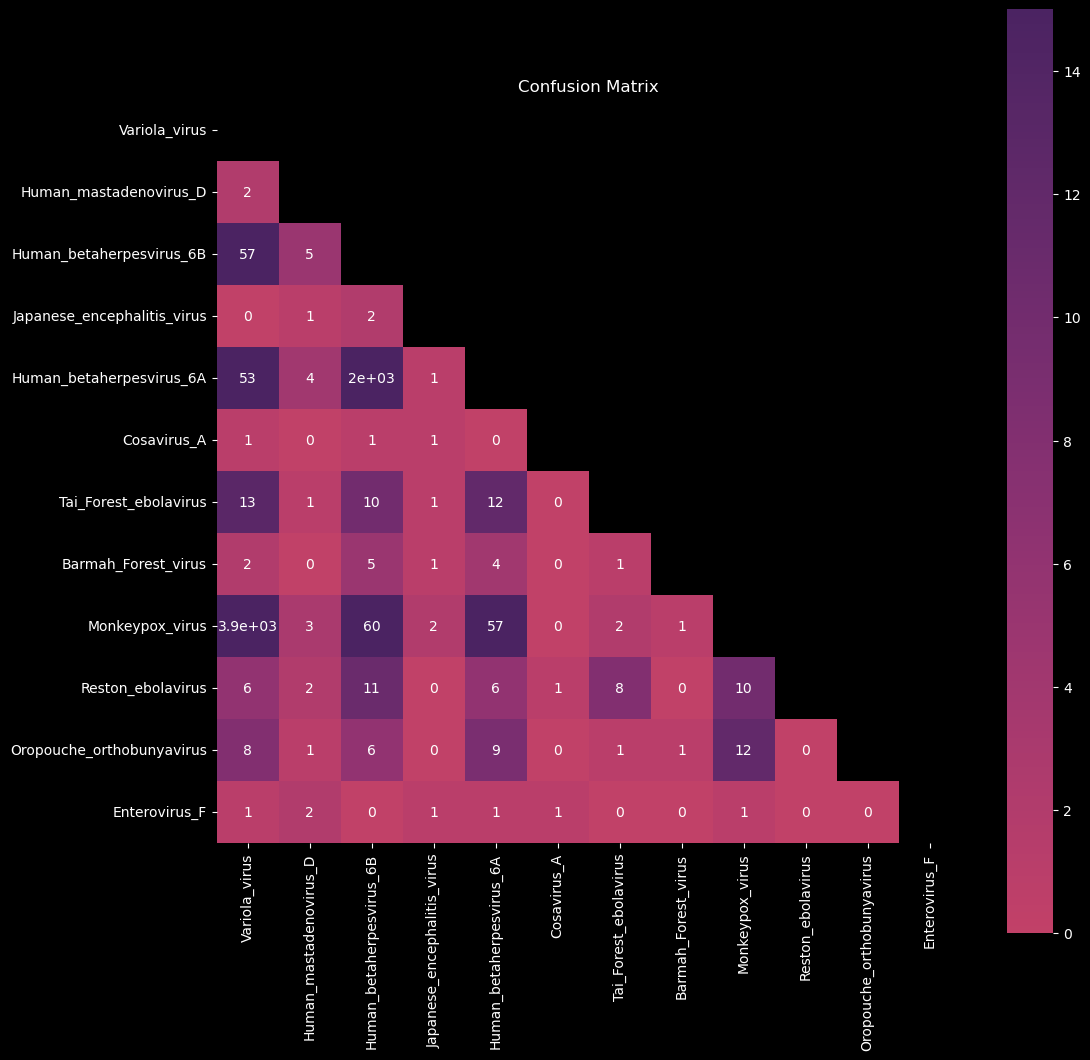

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax.set_xlabel('Predictions')
ax.set_ylabel('Actuals')
ax.set_title('Confusion Matrix')

mask = np.triu(np.ones_like(smallest_df.values), k=0).astype(bool)
sns.heatmap(smallest_df, mask=mask, center=0, vmax=15, cmap=cmap, square=True, annot=True, ax=ax);

# New Section